# Estimate car vs bus travel time

* Pull out parallel routes. Run `setup_parallel_trips_with_stops.py`
* Make car travel down same route as the bus. Use `googlemaps`, and set the departure hour to be the same time as bus route's.
    * `osmx` snaps to nodes, but even for every 5th bus stop, it's snapping to same node.
    * `osrm` wasn't able to be installed in Hub

In [ ]:
#!pip install -r requirements.txt

In [1]:
#https://stackoverflow.com/questions/55162077/how-to-get-the-driving-distance-between-two-geographical-coordinates-using-pytho
import dotenv
import geopandas as gpd
import googlemaps
import intake
import os
import pandas as pd

from datetime import datetime, timedelta, date
from siuba import *

dotenv.load_dotenv("_env")

catalog = intake.open_catalog("./*.yml")

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def grab_latlon_make_tuple(df, point_geom_col):
    # Change this from shapely point to floats
    df = df.assign(
        longitude = df[point_geom_col].x,
        latitude = df[point_geom_col].y,
    )
    
    # Make tuples instead of just floats
    df2 = (df.assign(
            new = df.apply(lambda x: (x.latitude, x.longitude), axis=1)        
        ).rename(columns = {"new": f"{point_geom_col}_tuple"})
          .drop(columns = ["latitude", "longitude"])
    )
    
    return df2

In [3]:
def data_wrangling(df):
    # Move this step into script later? 
    # Or just leave in this notebook, wrangle it into what goes into googlemaps
    df["first_departure"] = pd.to_datetime(df.trip_first_departure_ts, unit='s').dt.time

    def assemble_trip_departure_datetime(x):
        if (x.departure_time != None) and int(x.departure_time.split(':')[0]) < 23:
            return  str(x.date) + " " + str(x.departure_time)
        else: 
            return str(x.date) + " " + str(x.first_departure)


    df["trip_departure"] = df.apply(lambda x: assemble_trip_departure_datetime(x), axis=1)
    df["trip_departure"] = pd.to_datetime(df.trip_departure, errors="coerce")
    
    df2 = (grab_latlon_make_tuple(df, "geometry")
           .drop(columns = ["geometry", "date", "is_in_service",
                            "departure_time", "trip_first_departure_ts", 
                            "first_departure"])
           .rename(columns = {"geometry_tuple": "geometry"})
          )
    
    return df2

In [4]:
df = catalog.parallel_trips_with_stops.read()

df = data_wrangling(df)

every 3rd 

* origin = 1
* destination >= 77 & destination <= 79
* divisible by 3, remainder 1
* 4, 7, 10, 13, 16, 
* 19, 22, 25, 28, 31
* 34, 37, 40, 43, 46,
* 49, 52, 55, 58, 61,
* 64, 67, 70, 73, 76,

every 4th
* origin = 1
* destination >= 79 & destination <= 105
* divisible by 4, remainder 1
* 5, 9, 13, 17, 21,
* 25, 29, 33, 37, 41, 
* 45, 49, 53, 57, 61
* 65, 69, 73, 77, 81,
* 85, 89, 93, 97, 101

every 5th
* origin = 1
* destination >= 126 & destination <= 131
* divisible by 5, remainder 1
* 6, 11, 16, 21, 26,
* 31, 36, 41, 46, 51,
* 56, 61, 66, 71, 76,
* 81, 86, 91, 96, 101,
* 106, 111, 116, 121, 126

In [5]:
# If you have more than 25 waypoints, you have to break it into 2 requests
# (x - first_waypoint_rank) / divisible_by) + 1 = 25
# 25 waypoints in the middle, then allow origin and destination to bookend it
# origin = stop1
# destination is >= last_waypoint_rank & <= last_waypoint_rank + divisible_by
# can allow destination to be last_waypoint_rank

def last_waypoint_and_destination_rank(divisible_by):
    first = 1
    first_waypoint = first + divisible_by
    # (x- first_waypoint) / divisible_by) + 1 = 25
    # Solve for x
    x = (divisible_by * 24) + first_waypoint
    return x, x+divisible_by

In [6]:
trip_group = ["calitp_itp_id", "route_id", "trip_id", "shape_id"]

def subset_stops(df):
    # https://stackoverflow.com/questions/25055712/pandas-every-nth-row
    # df = df.iloc[::3]
    df["stop_rank"] = df.groupby(trip_group).cumcount() + 1
    df["max_stop"] = df.groupby(trip_group)["stop_rank"].transform("max")
    
    # every 3rd for shorter routes
    # every 4th, 5th for longer ones...stay under 25 waypoints
    every_third, dest3_max = last_waypoint_and_destination_rank(divisible_by=3)
    every_fourth, dest4_max = last_waypoint_and_destination_rank(divisible_by=4)
    every_fifth, dest5_max = last_waypoint_and_destination_rank(divisible_by=5)
    # Do we want to go beyond every 5th? Maybe need to investigate 
    
    def tag_waypoints(row):
        flag = 0
        if row.max_stop <= dest3_max:
            # Want remainder of 1, because if we are keeping stop 1, then 3rd stop is stop 4.
            if row.stop_rank % 3 == 1:
                flag=1
        elif (row.max_stop > dest3_max) and (row.max_stop <= dest4_max):
            if row.stop_rank % 4 == 1:
                flag = 1
        elif (row.max_stop > dest4_max) and (row.max_stop <= dest5_max):
            if row.stop_rank % 5 == 1:
                flag = 1
        return flag

    df["is_waypoint"] = df.apply(tag_waypoints, axis=1)
    df["is_od"] = df.apply(lambda x: 
                           1 if ((x.stop_rank==1) or (x.stop_rank==x.max_stop))
                           else 0, axis=1)
                           
    # Can have up to 25 waypoints to not be charged
    # we also have origin and destination
    subset = (df[(df.is_waypoint==1) | 
                (df.is_od==1) 
               ].drop(columns = ["stop_rank", "max_stop"])
              .reset_index(drop=True)
             )
    
    return subset

In [7]:
subset = subset_stops(df)

In [8]:
# Selecting 2 trips
keep_trips = [
    -7505741281882708052,
    -8806955513757008482 
]

subset = subset[subset.trip_key.isin(keep_trips)].reset_index(drop=True)

In [9]:
def select_origin_destination(df):
    df = df[df.is_od==1].reset_index(drop=True)
    
    # Wrangle it so there are columns with previous point and current point in the same row
    df = df.assign(
        previous = (df.sort_values(trip_group + ["stop_sequence"])
                        .groupby(trip_group)["geometry"]
                        .apply(lambda x: x.shift(1))
                       ),
    )
    
    # Only keep the observation that has start_geom (drop the first obs for each trip grouping)
    df2 = (df[df.previous.notna()]
           [trip_group + ["day_name", "trip_departure", "geometry", "previous"]]
           .assign(
               # test a week, 6 weeks from now, google maps probs does day of week/time of day, not seasonal
               departure_in_one_year = df.apply(lambda x: 
                                                x.trip_departure + timedelta(weeks=52), 
                                                axis=1)
           )
           .reset_index(drop=True)
           .rename(columns = {"geometry": "destination", 
                              "previous": "origin"})
          )
    
    return df2

In [10]:
def assemble_waypoints(df):
    df = df[(df.is_waypoint==1) & (df.is_od==0)].reset_index(drop=True)
    
    # Take all the stops in between origin/destination, put tuples into a list
    #https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
    waypoint_df = (
        df.sort_values(trip_group + ["stop_sequence"])
        .groupby(trip_group)
        .agg({"geometry": lambda x: list(x)})
        .reset_index()
        .rename(columns = {"geometry": "waypoints"})
    )
    
    return waypoint_df

In [11]:
od = select_origin_destination(subset)
waypoints_by_trip = assemble_waypoints(subset)

In [12]:
final = pd.merge(od, waypoints_by_trip, 
                 on = trip_group, how = "inner", validate = "1:1"
                )

final.head()

,calitp_itp_id,route_id,trip_id,shape_id,day_name,trip_departure,destination,origin,departure_in_one_year,waypoints
0,4,10,13277020,shp-10-10,Thursday,2022-01-06 07:08:00,"(37.670239, -122.08718)","(37.721266, -122.160201)",2023-01-05 07:08:00,"[(37.72521, -122.156367), (37.720677, -122.150..."
1,182,910-13153,10910002100513-DEC21,9100210_DEC21,Thursday,2022-01-06 06:02:00,"(33.869338, -118.287306)","(34.072191, -118.045132)",2023-01-05 06:02:00,"[(34.053943, -118.232454), (34.054622, -118.24..."


#### Caching
* If the Google API feels too slow, parallelize in some way, async io
* `functools` caching: write a function, take beginning, end, waypoints, departure time, and have that function reference the map's call
* `maxsize=None`, cache 
* since request output is dictionary, can save as pickle. request/response, save as pickle to be "cache"

#### Google Requests
* if there are any keys that don't have `duration_in_traffic`, throw an error and it's not getting what we expect

In [13]:
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

In [14]:
origin = final.origin.tolist()
dest = final.destination.tolist()
departures = final.departure_in_one_year.tolist()
waypts = final.waypoints.tolist()

print(f"type of origin input: {type(origin)}")
print(f"type of first row: {type(origin[0])}")

for i, tup in enumerate(zip(origin, dest)):
    if i == 0:
        print(i, tup)
        print(tup[0])
        print(departures[i])
        print(waypts[i])
        print(type(waypts[i]))

type of origin input: <class 'list'>
type of first row: <class 'tuple'>
0 ((37.721266, -122.160201), (37.670239, -122.08718))
(37.721266, -122.160201)
2023-01-05 07:08:00
[(37.72521, -122.156367), (37.720677, -122.15017), (37.715484, -122.143261), (37.71062, -122.136455), (37.703598, -122.126401), (37.698392, -122.12475), (37.699597, -122.120677), (37.694546, -122.113442), (37.688329, -122.104643), (37.681775, -122.096093), (37.674909, -122.087448)]
<class 'list'>


### Test 1 query

In [17]:
# Just do 1 query
beginning = (37.721266, -122.160201)
ending = (37.670239, -122.08718)
departures1 = departures[0]
waypts1 = waypts[0]

#### Compare waypoints (stop overs) with via travel time results

* Waypoints, when defined, are using stop overs
* If you use `via:` to define it, you will return `duration_in_traffic`, which is probably the more accurate result, since the car and the bus are both sitting in the same traffic
* Able to submit `via:` with lat/lon points, don't just have to use place names.

In [19]:
waypoints = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=departure1, 
                 waypoints=waypts1
                )

via = gmaps.directions(beginning, ending, 
                 mode='driving', 
                 departure_time=datetime.now() + timedelta(hours=4), 
                 waypoints=[f"via:{lat},{lon}" for lat, lon in waypts1]
                )

In [23]:
# https://stackoverflow.com/questions/25052980/use-pickle-to-save-dictionary-in-python
import pickle

def pickle_request(my_list, name):
    # result comes back as a list, but add [0] and it's a dict
    my_dict = my_list[0]
    pickle.dump(my_dict, open(f"{name}.p", "wb"))
            
    # To read in pickle
    # dct_read = pickle.load(open("save.p", "rb"))

In [24]:
pickle_request(waypoints, "waypoints_testquery")
pickle_request(via, "via_testquery")

In [25]:
# Same keys, but storing different info in legs
via[0].keys(), waypoints[0].keys()

(dict_keys(['bounds', 'copyrights', 'legs', 'overview_polyline', 'summary', 'warnings', 'waypoint_order']),
 dict_keys(['bounds', 'copyrights', 'legs', 'overview_polyline', 'summary', 'warnings', 'waypoint_order']))

In [27]:
via_traffic = via[0]["legs"][0]["duration_in_traffic"]
via_duration = via[0]["legs"][0]["duration"]
waypoints_duration = sum(leg["duration"]["value"] for leg in waypoints[0]["legs"])

print(f"via duration_in_traffic: {via_traffic}")
print(f"via sum(duration): {via_duration}") 
print(f"waypoints sum(duration) across legs: {waypoints_duration}")

via duration_in_traffic: {'text': '33 mins', 'value': 1953}
via sum(duration): {'text': '30 mins', 'value': 1821}
waypoints sum(duration) across legs: 1818


In [28]:
waypoints[0]["legs"][0]

{'distance': {'text': '0.6 mi', 'value': 896},
 'duration': {'text': '3 mins', 'value': 197},
 'end_address': 'E 14th St:W Estudillo Av, San Leandro, CA 94577, USA',
 'end_location': {'lat': 37.7253055, 'lng': -122.1562549},
 'start_address': 'San Leandro BART, San Leandro, CA 94577, USA',
 'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
 'steps': [{'distance': {'text': '0.2 mi', 'value': 302},
   'duration': {'text': '1 min', 'value': 83},
   'end_location': {'lat': 37.7235451, 'lng': -122.1620907},
   'html_instructions': 'Head <b>northwest</b> toward <b>Davis St</b>',
   'polyline': {'points': 'clfeFfnrhVMHgAp@IHGBOBKDiBdAu@d@A@GBsAt@_@R_Ah@'},
   'start_location': {'lat': 37.7211383, 'lng': -122.1605215},
   'travel_mode': 'DRIVING'},
  {'distance': {'text': '0.3 mi', 'value': 526},
   'duration': {'text': '2 mins', 'value': 100},
   'end_location': {'lat': 37.7257391, 'lng': -122.1567988},
   'html_instructions': 'Turn <b>right</b> onto <b>Davis St</b>',
   'maneuver':

In [31]:
via[0]["legs"][0].keys(), waypoints[0]["legs"][0].keys()

(dict_keys(['distance', 'duration', 'duration_in_traffic', 'end_address', 'end_location', 'start_address', 'start_location', 'steps', 'traffic_speed_entry', 'via_waypoint']),
 dict_keys(['distance', 'duration', 'end_address', 'end_location', 'start_address', 'start_location', 'steps', 'traffic_speed_entry', 'via_waypoint']))

In [33]:
w1 = waypoints[0]

In [34]:
#https://stackoverflow.com/questions/15380712/how-to-decode-polylines-from-google-maps-direction-api-in-php
def decode_polyline(polyline_str):
    index, lat, lng = 0, 0, 0
    coordinates = []
    changes = {'latitude': 0, 'longitude': 0}

    # Coordinates have variable length when encoded, so just keep
    # track of whether we've hit the end of the string. In each
    # while loop iteration, a single coordinate is decoded.
    while index < len(polyline_str):
        # Gather lat/lon changes, store them in a dictionary to apply them later
        for unit in ['latitude', 'longitude']: 
            shift, result = 0, 0

            while True:
                byte = ord(polyline_str[index]) - 63
                index+=1
                result |= (byte & 0x1f) << shift
                shift += 5
                if not byte >= 0x20:
                    break

            if (result & 1):
                changes[unit] = ~(result >> 1)
            else:
                changes[unit] = (result >> 1)

        lat += changes['latitude']
        lng += changes['longitude']

        coordinates.append((lat / 100000.0, lng / 100000.0))

    return coordinates

In [35]:
polyline = w1["overview_polyline"]

#https://github.com/geodav-tech/decode-google-maps-polyline
polyline_decoded = decode_polyline(polyline["points"])

In [36]:
polyline_gdf = (pd.DataFrame(polyline_decoded, )
                .rename(columns = {0: "longitude", 1: "latitude"})
               )

polyline_gdf = gpd.GeoDataFrame(polyline_gdf, 
                                geometry=gpd.points_from_xy(polyline_gdf.longitude, 
                                                           polyline_gdf.latitude), 
                                crs="EPSG:4326")

In [37]:
import shapely

polyline_gdf['group'] = 1

polyline_gdf2 = polyline_gdf.groupby("group")["geometry"].apply(
    lambda x: shapely.geometry.LineString(x.tolist())).reset_index()


<AxesSubplot:>

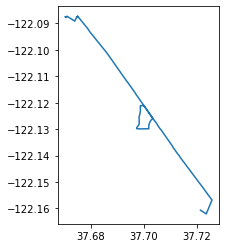

In [38]:
polyline_gdf2.plot()